In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Programmable Biology Group/Srikar/Code/cells/tf-flow-design/')

In [3]:
!ls

arboreto	       cvae-reference-code  pySCENIC	      raw_data
combined_adata_folder  data_generation	    pyscenic_env      tf-flow
concat_adata	       flow-matching-codes  pyscenic_results


## pip installs

In [4]:
import pandas as pd
import numpy as np
import os, glob
import pickle## Pyscenic grn+enrichment+ranking
import sys

# ! git clone https://github.com/aertslab/arboreto.git
# !git clone https://github.com/aertslab/pySCENIC.git

os.chdir('/content/drive/MyDrive/Programmable Biology Group/Srikar/Code/cells/tf-flow-design/arboreto/')
sys.path.append(os.getcwd())

!pip install distributed
!pip install dask-expr
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
!pip install scanpy anndata palantir bbknn
import scanpy as sc
import anndata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━

## data-generation workflow



In [5]:
os.chdir('/content/drive/MyDrive/Programmable Biology Group/Srikar/Code/cells/tf-flow-design/')

# Directory setup
input_dir = "/content/drive/MyDrive/Programmable Biology Group/Srikar/Code/cells/tf-flow-design/concat_adata/"
output_dir = '/content/drive/MyDrive/Programmable Biology Group/Srikar/Code/cells/tf-flow-design/data_generation/'
os.makedirs(output_dir, exist_ok=True)

In [6]:
%cd /content/drive/MyDrive/Programmable Biology Group/Srikar/Code/cells/tf-flow-design/
!ls

/content
arboreto	       cvae-reference-code  pySCENIC	      raw_data
combined_adata_folder  data_generation	    pyscenic_env      tf-flow
concat_adata	       flow-matching-codes  pyscenic_results


In [7]:
import os
import subprocess
import warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numba.core.errors import NumbaWarning
import scanpy as sc
import pickle
import scanpy as sc
import anndata
import pandas as pd
import os
import pickle
import palantir
import bbknn

# Inline plotting
%matplotlib inline
warnings.simplefilter('ignore', category=NumbaWarning)


In [13]:
import itertools


In [12]:
def combine_data(adata, output_dir):
    """
    Combine data for each unique pair of cell ontology class and organ tissue combinations.
    """
    combined_adatas = {}
    os.makedirs(output_dir, exist_ok=True)

    unique_combinations = adata.obs[['cell_ontology_class', 'organ_tissue']].drop_duplicates()
    total_combinations = unique_combinations.shape[0]
    print(f"Total unique combinations: {total_combinations}")

    # Create a dictionary to store subsets for each unique combination
    subsets = {}
    for idx, (class_name, organ) in enumerate(unique_combinations.itertuples(index=False), 1):
        criteria = (adata.obs['cell_ontology_class'] == class_name) & (adata.obs['organ_tissue'] == organ)
        subset = adata[criteria]

        if subset.shape[0] == 0:
            print(f"No cells found for class {class_name} in organ {organ}. Skipping...")
            continue

        subsets[(class_name, organ)] = subset
        print(f"Processed {idx}/{total_combinations} individual combinations")

    # Generate all possible pairs of combinations
    all_pairs = list(itertools.combinations(subsets.keys(), 2))
    total_pairs = len(all_pairs)
    print(f"Total number of pairs to process: {total_pairs}")

    for idx, ((class1, organ1), (class2, organ2)) in enumerate(all_pairs, 1):
        combined_adata_file = os.path.join(output_dir, f'combined_adata_{class1}_{organ1}__{class2}_{organ2}.h5ad')

        if os.path.exists(combined_adata_file):
            print(f"File already exists for {class1}_{organ1} __ {class2}_{organ2}. Skipping...")
            continue

        subset1 = subsets[(class1, organ1)]
        subset2 = subsets[(class2, organ2)]

        combined_adata = anndata.concat([subset1, subset2])
        combined_adatas[((class1, organ1), (class2, organ2))] = combined_adata
        combined_adata.write(combined_adata_file)

        print(f"Processed pair {idx}/{total_pairs}: {class1}_{organ1} __ {class2}_{organ2}")

    combined_adatas_files = {((class1, organ1), (class2, organ2)):
                             os.path.join(output_dir, f'combined_adata_{class1}_{organ1}__{class2}_{organ2}.h5ad')
                             for ((class1, organ1), (class2, organ2)) in combined_adatas}

    with open(os.path.join(output_dir, 'combined_adatas_files.pkl'), 'wb') as f:
        pickle.dump(combined_adatas_files, f)

    return combined_adatas_files

In [9]:
adata = sc.read_h5ad('/content/drive/MyDrive/Programmable Biology Group/Srikar/Code/cells/tf-flow-design/raw_data/TabulaSapiens.h5ad')
msc_rows = adata[adata.obs['cell_ontology_class'] == "mesenchymal stem cell"]

In [ ]:
combined_data_dir = "/content/drive/MyDrive/Programmable Biology Group/Srikar/Code/cells/tf-flow-design/concat_adata/"
os.makedirs(combined_data_dir, exist_ok=True)
combined_adatas_files = combine_data(adata, combined_data_dir)

Total unique combinations: 474
Processed 1/474 individual combinations
Processed 2/474 individual combinations
Processed 3/474 individual combinations
Processed 4/474 individual combinations
Processed 5/474 individual combinations
Processed 6/474 individual combinations
Processed 7/474 individual combinations
Processed 8/474 individual combinations
Processed 9/474 individual combinations
Processed 10/474 individual combinations
Processed 11/474 individual combinations
Processed 12/474 individual combinations
Processed 13/474 individual combinations
Processed 14/474 individual combinations
Processed 15/474 individual combinations
Processed 16/474 individual combinations
Processed 17/474 individual combinations
Processed 18/474 individual combinations
Processed 19/474 individual combinations
Processed 20/474 individual combinations
Processed 21/474 individual combinations
Processed 22/474 individual combinations
Processed 23/474 individual combinations
Processed 24/474 individual combina

In [ ]:
def run_bbknn_integration(adata, batch_key='organ_tissue'):
    """
    Run BBKNN integration on the AnnData object.
    """
    bbknn.bbknn(adata, batch_key=batch_key)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=[batch_key, 'cell_ontology_class'], save='_cell_types_after_bbknn.png')
    return adata

def perform_pseudotime_analysis(adata, start_class, start_organ):
    """
    Perform pseudotime analysis with a specified starting point.
    """
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

    sc.tl.umap(adata)
    sc.tl.diffmap(adata, n_comps=10)
    sc.pp.neighbors(adata, use_rep='X_diffmap')

    # Set the root cell based on the specified starting point
    start_mask = (adata.obs['cell_ontology_class'] == start_class) & (adata.obs['organ_tissue'] == start_organ)
    if np.sum(start_mask) == 0:
        raise ValueError(f"No cells found for starting class {start_class} in organ {start_organ}")
    adata.uns['iroot'] = np.flatnonzero(start_mask)[0]
    sc.tl.dpt(adata, n_dcs=10)

    return adata

def run_palantir_analysis(adata, start_class, start_organ):
    """
    Run Palantir analysis with a specified starting point.
    """
    dm_res = palantir.utils.run_diffusion_maps(adata, n_components=10)
    ms_data = palantir.utils.determine_multiscale_space(adata)

    imputed_data = palantir.utils.run_magic_imputation(adata)

    palantir.plot.plot_diffusion_components(adata)
    plt.savefig('diffusion_components.png')
    plt.close()

    # Set the start cell based on the specified starting point
    start_mask = (adata.obs['cell_ontology_class'] == start_class) & (adata.obs['organ_tissue'] == start_organ)
    if np.sum(start_mask) == 0:
        raise ValueError(f"No cells found for starting class {start_class} in organ {start_organ}")
    start_cell = adata.obs_names[start_mask][0]

    # Define terminal states
    terminal_states = pd.Series(index=[], dtype='object')
    for cell_type, organ in adata.obs[['cell_ontology_class', 'organ_tissue']].drop_duplicates().itertuples(index=False):
        if cell_type != start_class or organ != start_organ:
            mask = (adata.obs['cell_ontology_class'] == cell_type) & (adata.obs['organ_tissue'] == organ)
            sampled_cells = adata.obs[mask].sample(n=min(10, mask.sum())).index
            for cell in sampled_cells:
                terminal_states[cell] = f"{cell_type}_{organ}"

    pr_res = palantir.core.run_palantir(adata, start_cell, num_waypoints=500, terminal_states=terminal_states)

    palantir.plot.plot_palantir_results(adata, pr_res)
    plt.savefig('palantir_results.png')
    plt.close()

    return pr_res

def run_grnboost2(adata):
    """
    Run GRNBoost2 on the AnnData object.
    """
    expression_matrix = adata.to_df()
    adjacency_matrix = grnboost2(expression_data=expression_matrix, verbose=True)
    return adjacency_matrix

def prioritize_genes(adj_matrix, start_class, start_organ, end_class, end_organ, output_dir):
    """
    Prioritize genes using PageRank algorithm.
    """
    G = nx.from_pandas_edgelist(df=adj_matrix, source='TF', target='target', edge_attr='importance')
    print(f'Loaded {len(G.nodes):,} genes with {len(G.edges):,} edges.')

    cutoff = 1
    print(f'Removing all edges with weight < {cutoff}...\n')
    bad_edges = [(s,t,w) for (s,t,w) in G.edges.data('importance') if w < cutoff]
    G.remove_edges_from(bad_edges)
    print(f'Graph now has {len(G.nodes):,} genes and {len(G.edges):,} edges.')

    pr = nx.pagerank(G, alpha=0.85, max_iter=50, weight='importance')

    prdf = pd.DataFrame(pd.Series(pr)).reset_index()
    prdf.columns = ['Gene', 'PageRank']

    ranked_genes = prdf.sort_values('PageRank', ascending=False)
    ranked_genes_file = os.path.join(output_dir, f'ranked_genes_{start_class}_{start_organ}_to_{end_class}_{end_organ}.csv')
    ranked_genes.to_csv(ranked_genes_file, index=False)

    return ranked_genes

def integrated_analysis(input_dir, output_dir):
    """
    Perform integrated analysis on all .h5ad files in the input directory.
    """
    all_results = {}
    processed_files = 0

    with open(os.path.join(input_dir, 'combined_adatas_files.pkl'), 'rb') as f:
        combined_adatas_files = pickle.load(f)

    for ((start_class, start_organ), (end_class, end_organ)), file_path in combined_adatas_files.items():
        adata = sc.read_h5ad(file_path)

        # Run BBKNN integration
        adata = run_bbknn_integration(adata)

        # Perform pseudotime analysis in both directions
        for direction in ['forward', 'reverse']:
            if direction == 'forward':
                start_c, start_o, end_c, end_o = start_class, start_organ, end_class, end_organ
            else:
                start_c, start_o, end_c, end_o = end_class, end_organ, start_class, start_organ

            adata_pseudo = perform_pseudotime_analysis(adata.copy(), start_c, start_o)
            sc.pl.umap(adata_pseudo, color=['dpt_pseudotime', 'cell_ontology_class', 'organ_tissue'],
                       save=f'_{start_c}_{start_o}_to_{end_c}_{end_o}_umap_pseudotime.png')

            # Run Palantir analysis
            pr_res = run_palantir_analysis(adata_pseudo, start_c, start_o)

            # Run GRNBoost2 (same for both directions)
            if direction == 'forward':
                adjacency_matrix = run_grnboost2(adata)

            # Prioritize genes
            ranked_genes = prioritize_genes(adjacency_matrix, start_c, start_o, end_c, end_o, output_dir)

            # Save top 10 genes to a file
            top_genes_output_path = os.path.join(output_dir, f"{start_c}_{start_o}_to_{end_c}_{end_o}_top_genes.txt")
            with open(top_genes_output_path, 'w') as f:
                for gene in ranked_genes['Gene'].head(10):
                    f.write(f"{gene}\n")

            all_results[(start_c, start_o, end_c, end_o)] = {
                'adata': adata_pseudo,
                'palantir_results': pr_res,
                'adjacency_matrix': adjacency_matrix,
                'ranked_genes': ranked_genes
            }

        processed_files += 1
        print(f"\nProcessed files: {processed_files}")

    return all_results

In [ ]:
results = integrated_analysis(input_dir, output_dir)

In [15]:
adata.obs['cell_ontology_class'].unique()

['macrophage', 'monocyte', 'endothelial cell of hepatic sinusoid', 'liver dendritic cell', 'nk cell', ..., 'pancreatic delta cell', 'duodenum glandular cell', 'immature natural killer cell', 'thymocyte', 'connective tissue cell']
Length: 177
Categories (177, object): ['acinar cell of salivary gland', 'adipocyte', 'adventitial cell', 'alveolar fibroblast',
                           ..., 'type i pneumocyte', 'type ii pneumocyte',
                           'vascular associated smooth muscle cell', 'vein endothelial cell']

In [20]:
adata[adata.obs['cell_ontology_class'] == "mesenchymal stem cell"].obs['organ_tissue'].unique()

['Fat', 'Muscle']
Categories (2, object): ['Fat', 'Muscle']

In [23]:
# Step 1: Get unique cell_ontology_class values
unique_cell_ontology_classes = adata.obs['cell_ontology_class'].unique()
print(f"Number of unique cell ontology classes: {len(unique_cell_ontology_classes)}")

# Step 2: Count unique combinations of cell_ontology_class and organ_tissue
unique_combinations = adata.obs[['cell_ontology_class', 'organ_tissue']].drop_duplicates()

# Step 3: For each unique cell ontology class, count how many organ tissues it splits into
split_counts = unique_combinations.groupby('cell_ontology_class').size()
print("\nNumber of organ tissues for each cell ontology class:")
print(split_counts)

# Step 4: Calculate the total number of unique scRNA objects
total_unique_scrna_objects = unique_combinations.shape[0]
print(f"\nTotal number of unique scRNA objects: {total_unique_scrna_objects}")
print(f"\nTotal datapoints to go from any-any cell state: {total_unique_scrna_objects*(total_unique_scrna_objects-1)}")


Number of unique cell ontology classes: 177

Number of organ tissues for each cell ontology class:
cell_ontology_class
acinar cell of salivary gland             1
adipocyte                                 1
adventitial cell                          2
alveolar fibroblast                       1
artery endothelial cell                   1
                                         ..
type i nk t cell                          3
type i pneumocyte                         1
type ii pneumocyte                        1
vascular associated smooth muscle cell    4
vein endothelial cell                     5
Length: 177, dtype: int64

Total number of unique scRNA objects: 474

Total datapoints to go from any-any cell state: 224202


<ipython-input-23-24ab3f82d0c2>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  split_counts = unique_combinations.groupby('cell_ontology_class').size()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


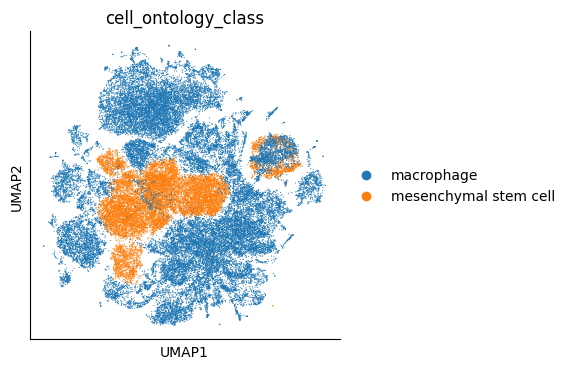

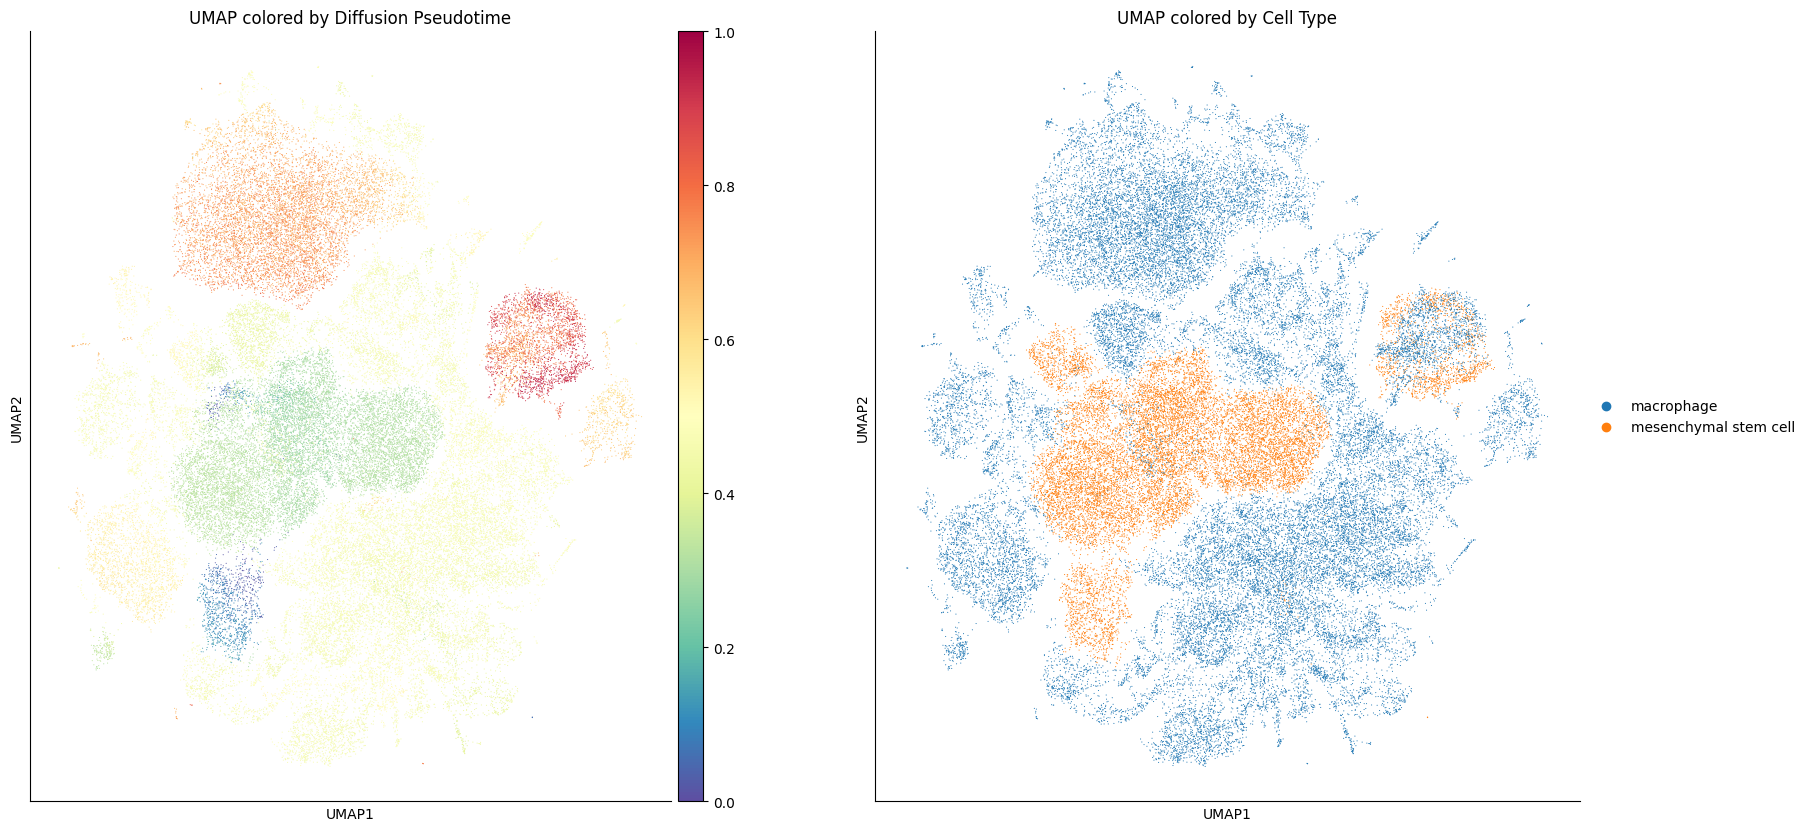

In [38]:
for file_name in os.listdir(input_dir):
        if file_name.endswith('.h5ad'):
            class_name = file_name.split('.')[0].split('combined_adata_')[-1]
            file_path = os.path.join(input_dir, file_name)

            adata = sc.read_h5ad(file_path)

            # Run BBKNN integration
            adata = run_bbknn_integration(adata)

            # show diffusion map of sc.tl.diffusion map is not good compared to palantir
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            sc.pl.umap(adata, color='dpt_pseudotime', ax=ax1, show=False, title='UMAP colored by Diffusion Pseudotime')
            sc.pl.umap(adata, color='cell_ontology_class', ax=ax2, show=False, title='UMAP colored by Cell Type')

            plt.show()
            break